# Noisy two-level system

We again consider a simple two-level system Hamiltonian

$$H(t) = -\frac{\omega_0}{2}\sigma_z + \Omega(t)\sigma_x$$

$$\dot{\rho} = -i[H, \rho]  + \sum_k \gamma_k \big( J_k \rho J_k^\dagger - \frac{1}{2} J_k^\dagger J_k \rho - \frac{1}{2} \rho J_k^\dagger J_k \big)$$

In [14]:
using Sisyphus
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using Random
using ProgressMeter

ProgressMeter.ijulia_behavior(:clear);

In [32]:
bs = SpinBasis(1//2)
n_neurons = 8
Random.seed!(0)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 1))
θ = Vector{Float64}(initial_params(ann));

println("Number of parameters: ", length(θ))

Ω(params, t) = (ann([t], params)[1] + ann([t1 - t], params)[1]) / 2;

Number of parameters: 169


In [33]:
(t0, t1) = (0.0, 1.0)
bcs(params) = Ω(params, t0)^2 + Ω(params, t1)^2
cost = CostFunction((x, y) -> sum(abs2.(x - y)), bcs);

In [40]:
trans = vectorize(StateTransform(spindown(bs)=>spinup(bs)))
J = [sigmam(bs)]
rates = [1.0]
H = Hamiltonian(-0.5*sigmaz(bs), [sigmax(bs)], coeffs)
Hv = vectorize(H, J, rates);

In [41]:
prob = QOCProblem(Hv, trans, (t0, t1), cost);

In [42]:
@time sol = solve(prob, θ, ADAM(0.01); maxiter=200, abstol=1e-6, reltol=1e-6);


Progress: 100%|█████████████████████████████████████████| Time: 0:02:15
  distance:     0.049036128614513494
  constraints:  0.0002110830983433885


136.228811 seconds (41.02 M allocations: 4.254 GiB, 92.81% gc time)


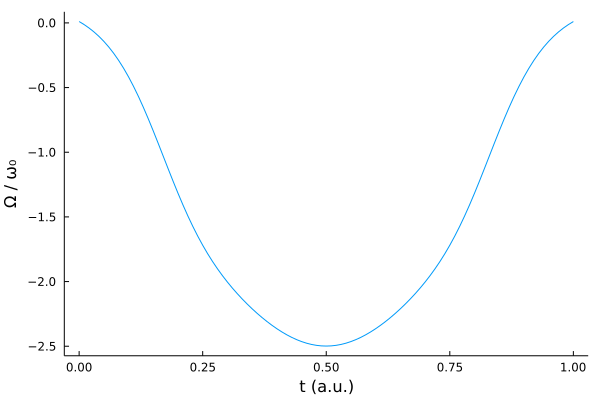

In [43]:
ts = t0:t1/100:t1

plot(ts, [Ω(sol.params, t) for t in ts])
plot!(xlabel="t (a.u.)", ylabel="Ω / ω₀", legend=false, grid=false)

In [44]:
tout, psit = master_dynamic(ts, spindown(bs), H, sol.params, J, rates);

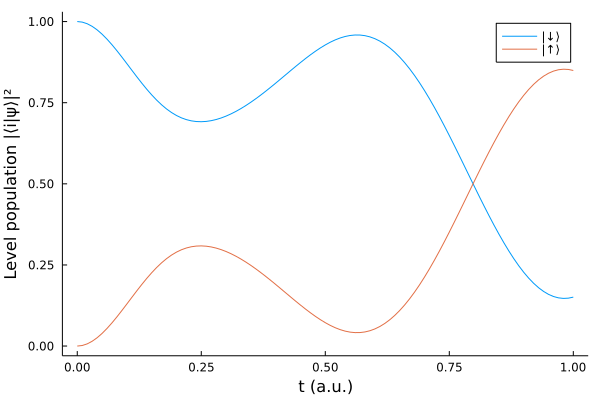

In [45]:
plot(tout, real(expect(dm(spindown(bs)), psit)), label="|↓⟩")
plot!(tout, real(expect(dm(spinup(bs)), psit)), label="|↑⟩")
plot!(xlabel="t (a.u.)", ylabel="Level population |⟨i|ψ⟩|²", grid=false)